In [1]:
%cd project/

/home/rapids/notebooks/project


In [ ]:
%pip install -r "requirements.txt"

In [2]:
import sys
import os
import numpy as np

from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 12) # (w, h)

from sklearn.model_selection import train_test_split

from random import sample
import pickle


TRAINING DATA

In [3]:
dir = "./matrices/adj/sem"
arrays = []
for filename in os.listdir(dir):
    if filename.endswith('.npy'):
        arrays.append(np.load(dir + "/"+filename))

v = arrays
img_size = v[0].shape[1]
v_train, v_test = train_test_split(v, test_size=0.2, random_state=42)
v = v_train
print(len(v_train), len(v_test), len(v))

cuda = True if torch.cuda.is_available() else False
print(cuda)

200 51 200
True


In [10]:
n_epochs = 6000
batch_size = 345
# n_epochs = 3000
# batch_size = 128

lr = 0.0002
b1 = 0.5
b2 = 0.999
# n_cpu = 8
latent_dim = 100
channels = 1
# sample_interval = 400

torch.manual_seed(3110)

In [9]:
class VectorialDataset(torch.utils.data.Dataset):
    def __init__(self, input_data, transform=None):
        super(VectorialDataset, self).__init__()
        self.input_data = torch.tensor(np.expand_dims(input_data, axis = 1)).float()
        self.transform = transform

    def __len__(self):
        return self.input_data.shape[0]
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = self.input_data[idx, :]

        if self.transform:
          sample = self.transform(sample)

        return sample 


In [37]:
training_set = VectorialDataset(input_data=v)
dataloader = torch.utils.data.DataLoader(training_set, 
                                           batch_size=batch_size, 
                                           shuffle=True)
for i, imgs in enumerate(dataloader):
  print(i, imgs.shape)

0 torch.Size([200, 1, 64, 64])


In [38]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


In [39]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.ReLU()
            #nn.Tanh()
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [40]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        #print("imgshape" + str(img.shape))
        #print("outshape" + str(out.shape))
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity


In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

INITIALIZATION

In [42]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)


# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2),weight_decay=1e-4)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr= lr, betas=( b1,  b2), weight_decay=1e-4)

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

TRAINING

In [43]:
G_losses = []
D_losses = []

real_scores = np.zeros(n_epochs)
fake_scores = np.zeros(n_epochs)

for epoch in range(n_epochs):
    for i, imgs in enumerate(dataloader):

        # Adversarial ground truths vectors
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0],  latent_dim))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        #Accuracies
        outputs = discriminator(real_imgs)
        real_score = outputs
        outputs = discriminator(gen_imgs.detach())
        fake_score = outputs

        d_loss.backward()
        optimizer_D.step()

        if epoch%10 == 0 and i == len(dataloader)-1:
            print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
            )
                    
        # Save Losses for plotting later and accuracies
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        real_scores[epoch] = real_scores[epoch]*(i/(i+1.)) + real_score.mean().data*(1./(i+1.))
        fake_scores[epoch] = fake_scores[epoch]*(i/(i+1.)) + fake_score.mean().data*(1./(i+1.))

print("end")

[Epoch 0/6000] [Batch 0/1] [D loss: 0.692120] [G loss: 0.701482]
[Epoch 10/6000] [Batch 0/1] [D loss: 0.528219] [G loss: 0.708593]
[Epoch 20/6000] [Batch 0/1] [D loss: 0.381669] [G loss: 0.724283]
[Epoch 30/6000] [Batch 0/1] [D loss: 0.341588] [G loss: 0.744819]
[Epoch 40/6000] [Batch 0/1] [D loss: 0.327811] [G loss: 0.764984]
[Epoch 50/6000] [Batch 0/1] [D loss: 0.289057] [G loss: 0.848358]
[Epoch 60/6000] [Batch 0/1] [D loss: 0.261535] [G loss: 0.921486]
[Epoch 70/6000] [Batch 0/1] [D loss: 0.226959] [G loss: 1.030014]
[Epoch 80/6000] [Batch 0/1] [D loss: 0.188286] [G loss: 1.179570]
[Epoch 90/6000] [Batch 0/1] [D loss: 0.150347] [G loss: 1.371369]
[Epoch 100/6000] [Batch 0/1] [D loss: 0.117564] [G loss: 1.603604]
[Epoch 110/6000] [Batch 0/1] [D loss: 0.087472] [G loss: 1.879454]
[Epoch 120/6000] [Batch 0/1] [D loss: 0.063219] [G loss: 2.190828]
[Epoch 130/6000] [Batch 0/1] [D loss: 0.045469] [G loss: 2.509168]
[Epoch 140/6000] [Batch 0/1] [D loss: 0.032586] [G loss: 2.839978]
[Epoch

PLOTS

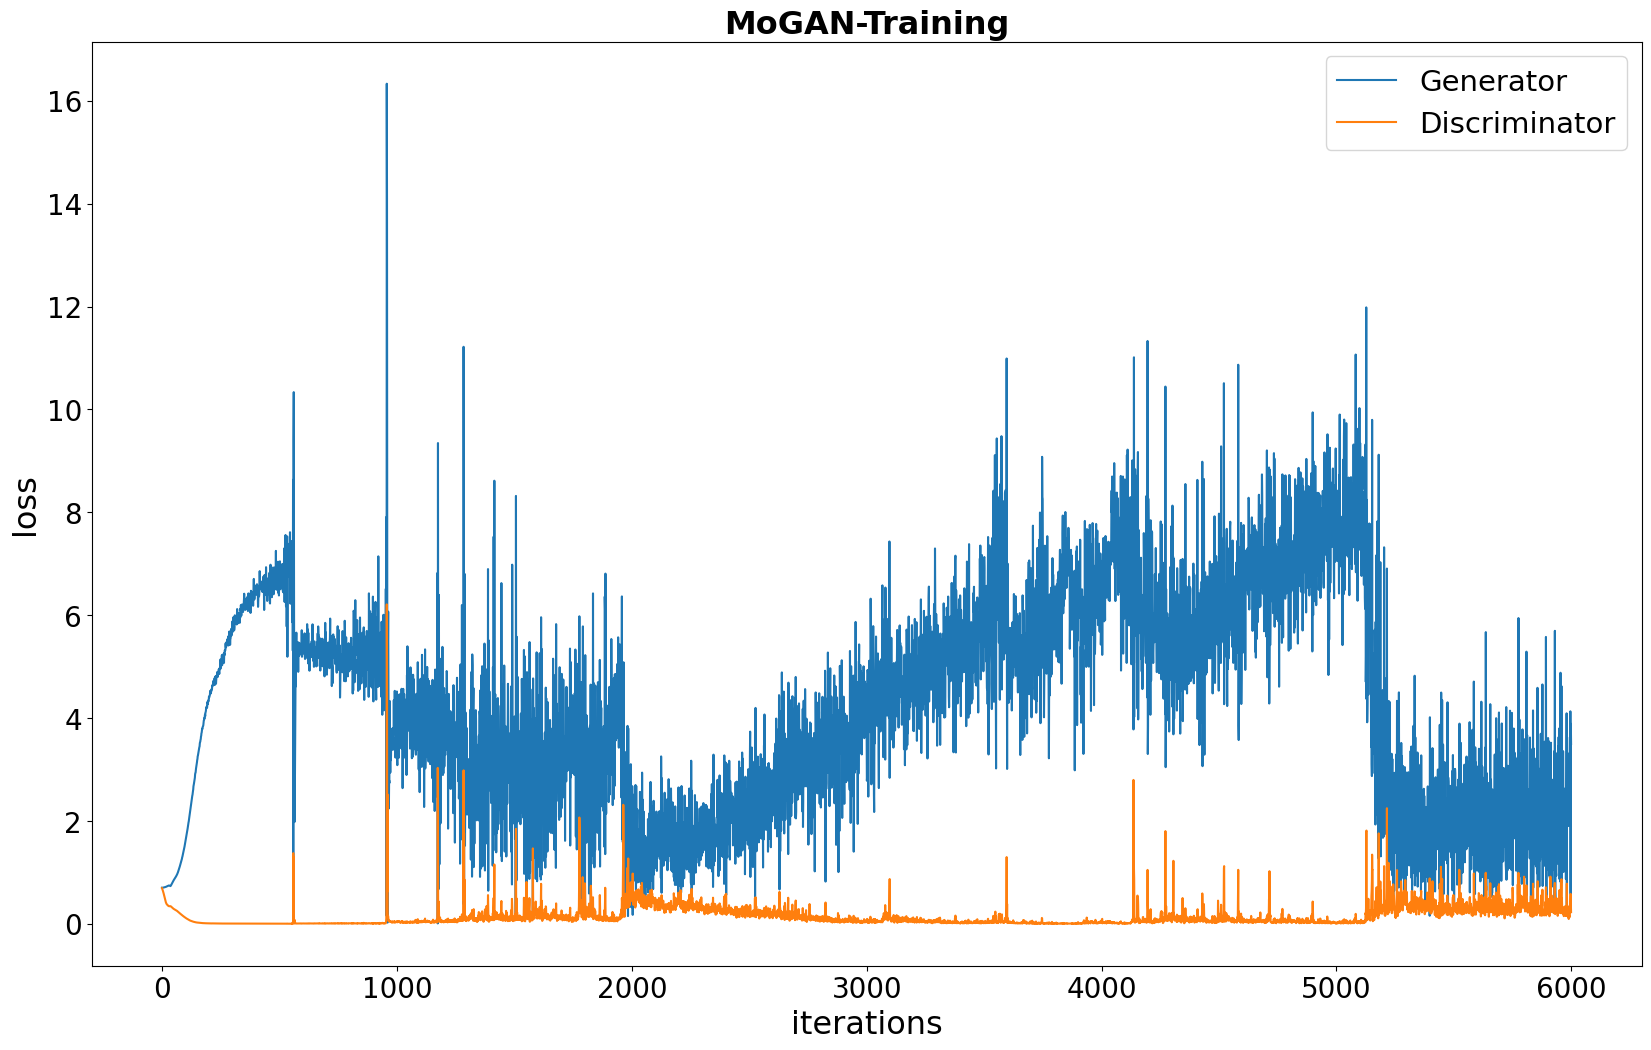

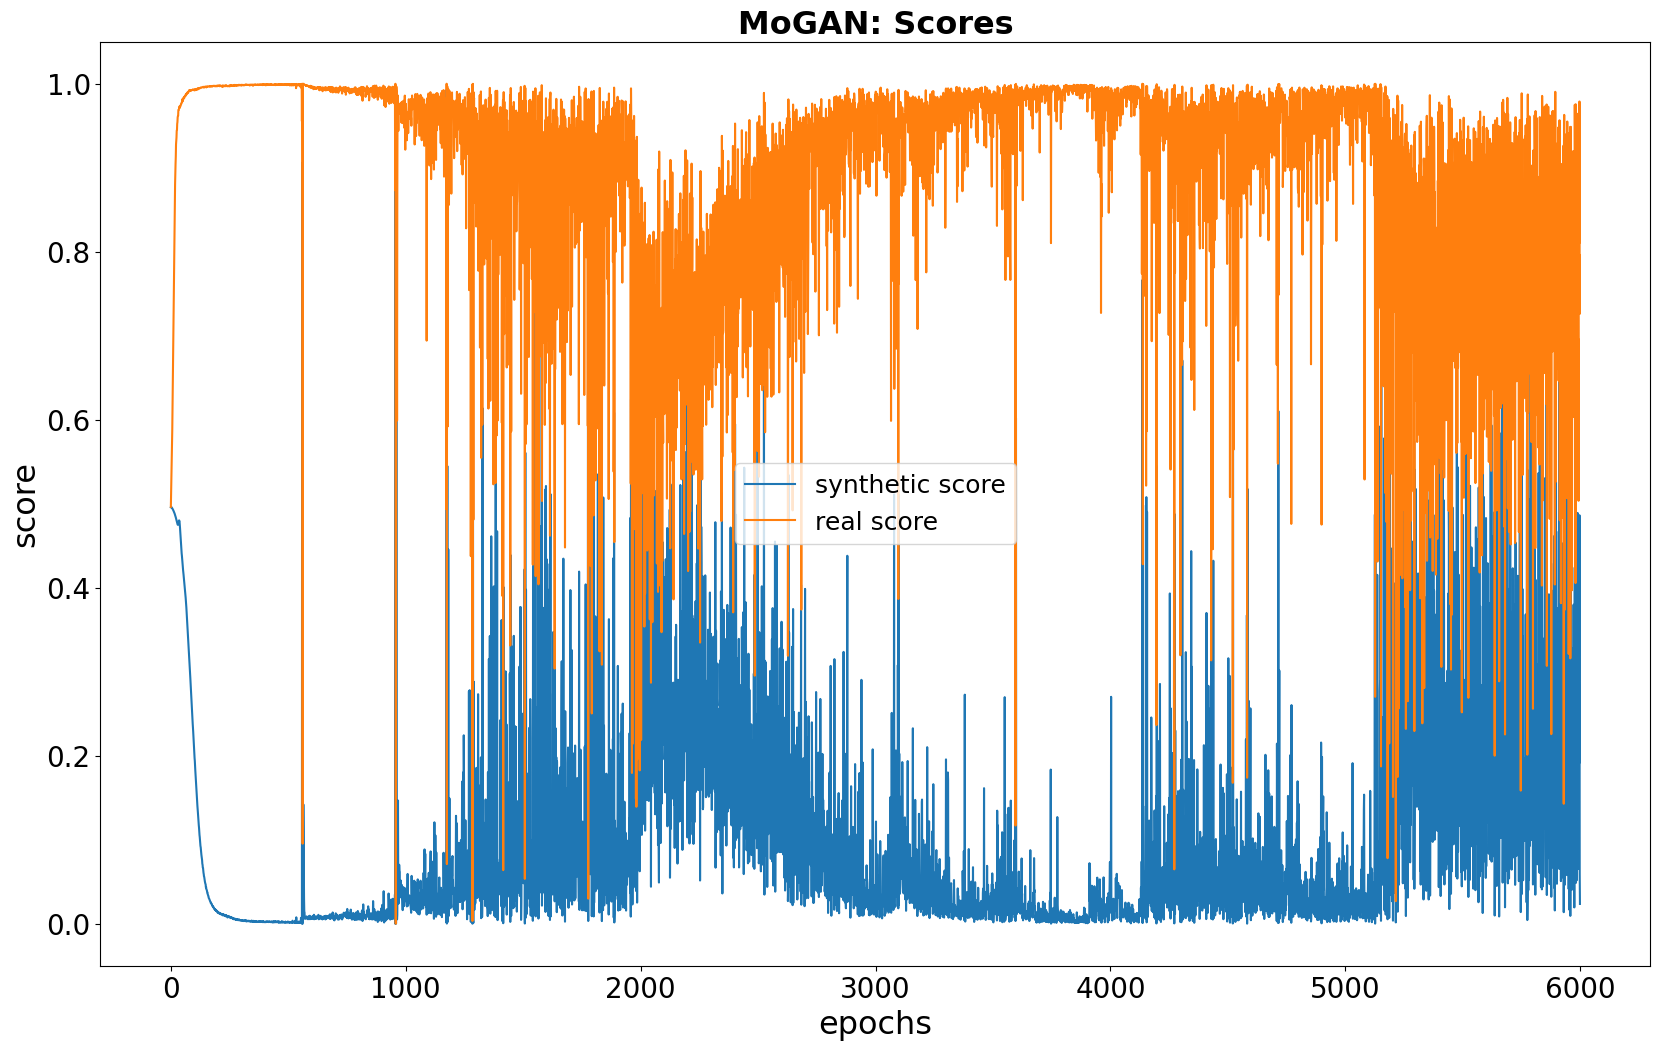

In [45]:

#######------PLOTS------#########
#######------#######------########
#######------#######------########

#Plot Losses
plt.title("MoGAN-Training", size = 23, fontweight="bold")
plt.plot(G_losses,label="Generator")
plt.plot(D_losses,label="Discriminator")
plt.xlabel("iterations", size = 23)
plt.ylabel("loss", size = 23)
plt.tick_params(labelsize=20)
plt.legend(prop={'size': 21})
plt.savefig("./generations/sem/lossMoGAN.pdf")  
plt.show(block=False)

#Plot Scores
plt.title("MoGAN: Scores", size = 23, fontweight="bold")
plt.plot(fake_scores, label='synthetic score')
plt.plot(real_scores, label='real score')    
plt.xlabel("epochs", size = 23)
plt.ylabel("score", size = 23)
plt.tick_params(labelsize=20)
plt.legend(prop={'size': 18})
plt.savefig("./generations/sem/scoresMoGAN.pdf")
plt.show(block=False)

In [46]:
def save_models(generator, discriminator, sufix):
  torch.save(generator.state_dict(), "./models/generator"+sufix+".pth")
  torch.save(discriminator.state_dict(), "./models/discriminator"+sufix+".pth")

def load_models(sufix):
  generator = Generator()
  discriminator = Discriminator()
  generator.load_state_dict(torch.load("./models/generator"+sufix+".pth"))
  discriminator.load_state_dict(torch.load("./models/discriminator"+sufix+".pth"))
  return generator, discriminator

Fake set and dump

In [48]:

#######------Fake set and dump------#########
#######------#######------########
#######------#######------########


fake_set = []
generator.eval()
t = torch.tensor(np.random.normal(0, 1, (len(v_test), latent_dim)), device='cuda', dtype=torch.float) # Ensure dtype is float
t = generator(t).detach().cpu().numpy()
print(t.shape)

for i in range(0, t.shape[0]):
  fake_set.append(np.rint(t[i][0]).astype(int))

print("len of fake set", len(fake_set))


with open("./generations/sem/fake_set.txt", "wb") as fp:   #Pickling
   pickle.dump(fake_set, fp) 

save_models(generator, discriminator, "MoGAN_sem_final")

(51, 1, 64, 64)
len of fake set 51


In [58]:
with open("./generations/v_test.txt", "wb") as fp:   #Pickling
  pickle.dump(v_test, fp) 

with open("./generations/v_train.txt", "wb") as fp:   #Pickling
  pickle.dump(v_train, fp) 

In [50]:
print(len(v_test), len(v_train))

51 200


In [49]:
fake_set

[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[ 0,  0,  0, ...,  0,  0,  3],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  6,  8, ...,  2,  0,  0],
        ...,
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0, 26, ..., 14, 47, 70]]),
 array([[ 0,  0,  0, ...,  0,  0, 18],
        [ 0,  0,  0, ..., 25,  0,  0],
        [ 0,  0,  0, ..., 43,  0,  0],
        ...,
        [ 0,  0,  9, ..., 13,  0,  0],
        [ 0,  0,  0, ...,  0, 12,  0],
        [ 0,  0,  0, ...,  0, 17, 72]]),
 array([[ 0,  0,  0, ...,  0,  0,  1],
        [ 0, 20,  0, ..., 13,  0,  0],
        [ 6, 18, 65, ..., 21,  0,  0],
        ...,
        [ 0,  0,  3, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  9, ..., 14,  2, 28]]),
 array([[ 0,  0,  0, ...,  0,  0,  0],
 